# Predictive Analysis: ANZ Synthesized 3-month Transactional Dataset

In [139]:
import pandas as pd
import reverse_geocoder as rg
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn import svm, naive_bayes
from sklearn.datasets import make_blobs
from sklearn.model_selection import learning_curve

%matplotlib inline

## Background

Source: https://www.theforage.com/modules/ZLJCsrpkHo9pZBJNY/BiJPfqmGY2QwgN6gA

This task is based on a synthesised transaction dataset containing 3 months’ worth of transactions for 100 hypothetical customers. It contains purchases, recurring transactions, and salary transactions. The dataset is designed to simulate realistic transaction behaviours that are observed in ANZ’s real transaction data, so many of the insights gathered from the activities will be genuine.

## Step 0: Load the dataset and perform EDA

### Overview
The aim of this dataset is to try to understand the features of purchasing behaviour of customers (independent variables) for modelling expected values for annualized salary (dependent variable)

In [140]:
# referencing the cleaned dataset
file = 'DATA/ANZ-synthesized-transactions-cleaned.csv'
# Read file and parse timestamp as the index
df = pd.read_csv(file)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          12043 non-null  object 
 1   status             12043 non-null  object 
 2   card_present_flag  6194 non-null   float64
 3   account            12043 non-null  int64  
 4   first_name         12043 non-null  object 
 5   age                12043 non-null  int64  
 6   gender             12043 non-null  object 
 7   txn_description    12043 non-null  object 
 8   balance            12043 non-null  float64
 9   amount             12043 non-null  float64
 10  geometry           12043 non-null  object 
 11  X                  12043 non-null  float64
 12  Y                  12043 non-null  float64
 13  merch_suburb       7717 non-null   object 
 14  merch_state        7717 non-null   object 
 15  merch_geometry     7717 non-null   object 
 16  merch_X            771

In [142]:
df.isnull().sum()

timestamp               0
status                  0
card_present_flag    5849
account                 0
first_name              0
age                     0
gender                  0
txn_description         0
balance                 0
amount                  0
geometry                0
X                       0
Y                       0
merch_suburb         4326
merch_state          4326
merch_geometry       4326
merch_X              4326
merch_Y              4326
distance             4334
country                 0
card_present_bool       0
dtype: int64

In [143]:
# Check the distinct values for each column
df.nunique()

timestamp             9231
status                   2
card_present_flag        1
account                100
first_name              80
age                     33
gender                   2
txn_description          6
balance              11920
amount                3980
geometry               100
X                       85
Y                       87
merch_suburb          1609
merch_state              8
merch_geometry        2674
merch_X                647
merch_Y                690
distance              3967
country                  1
card_present_bool        2
dtype: int64

In [144]:
df.head()

,timestamp,status,card_present_flag,account,first_name,age,gender,txn_description,balance,amount,...,X,Y,merch_suburb,merch_state,merch_geometry,merch_X,merch_Y,distance,country,card_present_bool
0,218-8-1 1:1:15+:,authorized,1.0,159845171,Diana,26,F,POS,35.39,16.25,...,-27.95,153.41,Ashmore,QLD,153.38 -27.99,-27.99,153.38,5.34,Australia,True
1,218-8-1 1:13:45+:,authorized,NaN,159845171,Diana,26,F,SALES-POS,21.20,14.19,...,-27.95,153.41,Sydney,NSW,151.21 -33.87,-33.87,151.21,691.63,Australia,False
2,218-8-1 1:26:15+:,authorized,1.0,12223524,Michael,38,M,POS,5.71,6.42,...,-33.94,151.23,Sydney,NSW,151.21 -33.87,-33.87,151.21,8.10,Australia,True
3,218-8-1 1:38:45+:,authorized,1.0,1375564,Rhonda,4,F,SALES-POS,2117.22,4.90,...,-27.66,153.10,Buderim,QLD,153.5 -26.68,-26.68,153.50,19.20,Australia,True
4,218-8-1 1:51:15+:,authorized,1.0,159845171,Diana,26,F,SALES-POS,17.95,3.25,...,-27.95,153.41,Mermaid Beach,QLD,153.44 -28.6,-28.60,153.44,12.60,Australia,True


In [145]:
df.txn_description.value_counts()

SALES-POS     3934
POS           3783
PAYMENT       2600
PAY/SALARY     883
INTER BANK     742
PHONE BANK     101
Name: txn_description, dtype: int64

<AxesSubplot:xlabel='txn_description', ylabel='amount'>

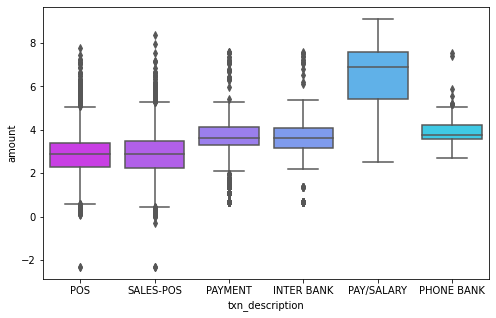

In [146]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='txn_description', y=np.log(df.amount), data=df, palette="cool_r")

In [147]:
df.gender.value_counts()

M    6285
F    5758
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='amount'>

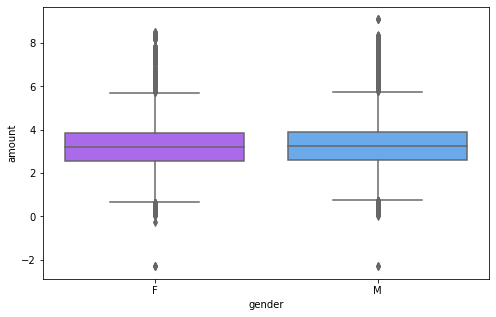

In [175]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='gender', y=np.log(df.amount), data=df, palette="cool_r")

In [86]:
df.merch_state.value_counts()

NSW    2169
VIC    2131
QLD    1556
WA     1100
SA      415
NT      205
ACT      73
TAS      68
Name: merch_state, dtype: int64

In [87]:
df_state_cat = df.groupby(['account', 'merch_state']).size().unstack(fill_value=0)

In [88]:
assert np.sum(df_state_cat[['ACT', 'NSW', 'NT', 'QLD', 'SA', 'TAS', 'VIC', 'WA']].sum(axis=1) != 0) \
            == len(df.groupby('account')), 'If dataframe is indexed on customer accounts, \
            then there will be no missing values for merchant information'

#### a) Drop irrelevant features

In [101]:
if ('status' or 'card_present_flag' or 'first_name' or 'country' or 'timestamp' \
    or 'geometry' or 'merch_suburb' or 'distance' or 'merch_geometry' or 'card_present_bool') in df:
    df = df.drop(columns=['status', 'card_present_flag', 'first_name','country', 
                        'timestamp', 'geometry', 'merch_suburb', 'distance',
                        'merch_geometry', 'card_present_bool'])

#### b) Conduct Feature engineering

In [102]:
def geocoder(data):
    '''
    input: dataframe containing Latitude(x) and Longitude(y) coordinates
    output: JSON data containing info on available building or street names.
    '''
    coordinates = list(zip(data.X, data.Y))
    results = rg.search(coordinates) # default mode = 2
    return results

list_1 = geocoder(df)

In [103]:
df_geocodes = pd.DataFrame.from_dict(list_1)

In [104]:
df_geocodes.head()

,lat,lon,name,admin1,admin2,cc
0,-27.96724,153.39796,Southport,Queensland,Gold Coast,AU
1,-27.96724,153.39796,Southport,Queensland,Gold Coast,AU
2,-33.93333,151.23333,Daceyville,New South Wales,Randwick,AU
3,-27.63917,153.10944,Logan City,Queensland,Logan,AU
4,-27.96724,153.39796,Southport,Queensland,Gold Coast,AU


In [105]:
df_geocodes.nunique()

lat       83
lon       85
name      87
admin1    11
admin2    60
cc         6
dtype: int64

In [106]:
df_geocodes.cc.value_counts()

AU    10513
ZA      830
AO      368
ID      134
AQ      123
NA       75
Name: cc, dtype: int64

* AU = Australia
* ZA = South Africa
* AO = Angola
* ID = Indonesia
* AQ = Antartica
* NA = Namibia

In [107]:
df_geocodes.admin1.value_counts()

Victoria             3716
Queensland           2360
New South Wales      1835
Western Australia    1716
Western Cape          830
South Australia       798
Benguela              368
Sulawesi Tenggara     134
                      123
Tasmania               88
Erongo                 75
Name: admin1, dtype: int64

In [108]:
check_null = df_geocodes.isnull().sum()

In [109]:
check_null

lat       0
lon       0
name      0
admin1    0
admin2    0
cc        0
dtype: int64

In [110]:
df_geocodes[~df_geocodes.admin1.str.contains('\w')].admin1.count()

123

In [111]:
df_geocodes.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [112]:
df_geocodes.isnull().sum()

lat         0
lon         0
name        0
admin1    123
admin2    973
cc          0
dtype: int64

In [113]:
df['cust_state'] = df_geocodes['admin1']
df['cc'] = df_geocodes['cc']

In [115]:
# get dummy variables
df = pd.get_dummies(data=df, columns=['gender', 'txn_description', 'merch_state', 'cust_state', 'cc'], 
                    prefix=['g', 't', 'm', 'c', 'cc'], drop_first=True)

In [120]:
# feature engineer from coordinates X and Y
x = df.X
y = df.Y

 **Source:** https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796

In [121]:
# geospatial feature engineering trick 1: Add 4 new features of Polar coordinates to the dataset
df['r'] = np.sqrt(x**2 + y**2)
df['phi'] = np.arctan2(y, x)
df['rot_x'] = np.cos(x) + np.sin(x)
df['rot_y'] = np.sin(x) - np.sin(y)

In [122]:
# geospatial feature engineering trick 2: Add 4 new features of rotational Cartesian coordinates

df['rot_45_x'] = (0.707 * x) + (0.707 * y)
df['rot_45_y'] = (0.707 * y) + (0.707 * x)
df['rot_30_x'] = (0.866 * x) + (0.5 * y)
df['rot_30_y'] = (0.866 * y) + (0.5 * x)

In [123]:
# geospatial feature engineering trick 3: Add new feature of Haversine distance to the dataset
x_1 = df.merch_X
y_1 = df.merch_Y

def haversine_dist(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

df['h_dist'] = haversine_dist(x, y, x_1, y_1)

In [124]:
def manhattan_dist(lat1, lng1, lat2, lng2):
    '''
    calculating two haversine distances by,
     - avoiding Latitude of one point 
     - avoiding Longitude of one point
    and adding it together.
    '''
    a = haversine_dist(lat1, lng1, lat1, lng2)
    b = haversine_dist(lat1, lng1, lat2, lng1)
    return a + b

df['m_dist'] = manhattan_dist(x, y, x_1, y_1)

In [125]:
def bearing_degree(lat1, lng1, lat2, lng2):
    '''
    calculate angle between two points
    '''
    radius = 6371  # Mean radius of Earth
    diff_lng = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(diff_lng) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(diff_lng)
    return np.degrees(np.arctan2(y, x))

df['b_deg'] = bearing_degree(x, y, x_1, y_1)

In [126]:
def pca(data):
    '''
    input: dataframe containing Latitude(x) and Longitude(y)
    '''
    coordinates = data[['X','Y']].values
    pca_obj = PCA().fit(coordinates)
    pca_x = pca_obj.transform(data[['X', 'Y']])[:,0]
    pca_y = pca_obj.transform(data[['X', 'Y']])[:,1]
    return pca_x, pca_y

df['pca_x'], df['pca_y'] = pca(df)

In [127]:
df.drop(columns=['X', 'Y', 'merch_X', 'merch_Y'], inplace=True)

In [128]:
df = df.rename(columns={'account': 'acc', 'balance': 'bal', 'amount': 'amt','t_PAY/SALARY': 't_pay', 't_PAYMENT': 't_pmt', 
                        't_PHONE BANK': 't_phb', 't_POS': 't_pos', 't_SALES-POS': 't_sales', 'c_Erongo': 'c_ER', 
                        'c_New South Wales': 'c_NSW', 'c_Queensland': 'c_QLD', 'c_South Australia': 'c_SA', 
                        'c_Sulawesi Tenggara': 'c_SULTRA', 'c_Tasmania': 'c_TAS', 'c_Victoria': 'c_VIC', 
                        'c_Western Australia': 'c_WA', 'c_Western Cape': 'c_WC'})

In [129]:
if '_NSW' not in df: 
    df['_NSW'] = df['c_NSW'] + df['m_NSW']
    df.drop(columns=['c_NSW', 'm_NSW'], inplace=True)
if '_QLD' not in df:
    df['_QLD'] = df['c_QLD'] + df['m_QLD']
    df.drop(columns=['c_QLD', 'm_QLD'], inplace=True)
if '_SA' not in df:
    df['_SA'] = df['c_SA'] + df['m_SA']
    df.drop(columns=['c_SA', 'm_SA'], inplace=True)
if '_TAS' not in df:
    df['_TAS'] = df['c_TAS'] + df['m_TAS']
    df.drop(columns=['c_TAS', 'm_TAS'], inplace=True)
if '_VIC' not in df:
    df['_VIC'] = df['c_VIC'] + df['m_VIC']
    df.drop(columns=['c_VIC', 'm_VIC'], inplace=True)
if '_WA' not in df:
    df['_WA'] = df['c_WA'] + df['m_WA']
    df.drop(columns=['c_WA', 'm_WA'], inplace=True)

In [130]:
df.columns

Index(['acc', 'age', 'bal', 'amt', 'g_M', 't_pay', 't_pmt', 't_phb', 't_pos',
       't_sales', 'm_NT', 'c_ER', 'c_SULTRA', 'c_WC', 'cc_AQ', 'cc_AU',
       'cc_ID', 'cc_NA', 'cc_ZA', 'r', 'phi', 'rot_x', 'rot_y', 'rot_45_x',
       'rot_45_y', 'rot_30_x', 'rot_30_y', 'h_dist', 'm_dist', 'b_deg',
       'pca_x', 'pca_y', '_NSW', '_QLD', '_SA', '_TAS', '_VIC', '_WA'],
      dtype='object')

## Step 1: Identify annual salary of each customer

### a) Subset Pay/Salary transactions and group by account

In [131]:
# display counts of payment types
total_sal = df.amt[df.t_pay == 1].groupby(df.acc).sum()
annual_sal = total_sal * 4
annual_sal = annual_sal.sort_values()

In [132]:
df = df.groupby('acc').mean()
df['a_sal'] = annual_sal

In [133]:
df.head()

,age,bal,amt,g_M,t_pay,t_pmt,t_phb,t_pos,t_sales,m_NT,...,b_deg,pca_x,pca_y,_NSW,_QLD,_SA,_TAS,_VIC,_WA,a_sal
acc,,,,,,,,,,,,,,,,,,,,,
958567,34,4736.124598,205.593678,0.0,0.040230,0.281609,0.000000,0.350575,0.293103,0.505747,...,17.327454,-74.407257,92.714269,0.074713,0.017241,0.000000,0.0,0.028736,0.017241,98493.08
1375564,4,2510.007683,71.145444,0.0,0.050193,0.100386,0.000000,0.428571,0.420849,0.000000,...,3.089790,1.077052,-25.237176,0.061776,1.714286,0.000000,0.0,0.046332,0.027027,46430.80
1566392,22,31965.638605,256.383837,1.0,0.069767,0.069767,0.000000,0.267442,0.406977,0.000000,...,-56.868299,6.800156,-13.698173,0.023256,0.000000,0.034884,0.0,1.616279,0.000000,76682.40
2484743,29,10137.490448,60.019776,1.0,0.052239,0.350746,0.097015,0.223881,0.276119,0.000000,...,-2.797769,-34.383113,-7.514613,0.164179,0.082090,0.007463,0.0,0.007463,0.231343,12468.40
2615387,43,20212.127500,208.970000,0.0,0.250000,0.096154,0.000000,0.192308,0.211538,0.000000,...,-23.538861,7.171829,-13.569880,0.019231,0.019231,0.000000,0.0,1.365385,0.000000,34550.36


## Step 2: EDA

In [134]:
df.describe()

,age,bal,amt,g_M,t_pay,t_pmt,t_phb,t_pos,t_sales,m_NT,...,b_deg,pca_x,pca_y,_NSW,_QLD,_SA,_TAS,_VIC,_WA,a_sal
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,27.360000,11297.004375,178.540553,0.560000,0.094944,0.248644,0.010218,0.283731,0.293591,0.013084,...,2.495377,0.162950,0.822367,0.344627,0.206924,0.105087,0.015562,0.547653,0.207054,46042.555200
std,15.220613,20898.005949,135.687430,0.498888,0.066505,0.159644,0.035562,0.101519,0.107645,0.084313,...,63.675489,57.999291,38.361108,0.516759,0.502226,0.322547,0.116942,0.697151,0.477177,37267.210968
min,2.000000,911.712805,21.284827,0.000000,0.008368,0.017241,0.000000,0.016667,0.000000,0.000000,...,-104.271455,-74.407257,-26.033951,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,600.000000
25%,19.000000,3611.222550,62.012350,0.000000,0.049485,0.127563,0.000000,0.215734,0.227860,0.000000,...,-53.337000,-10.970033,-20.767472,0.030888,0.000000,0.000000,0.000000,0.017080,0.000000,9150.720000
50%,26.000000,4729.864282,154.624111,1.000000,0.075000,0.212160,0.000000,0.299985,0.299878,0.000000,...,-3.997167,5.756018,-13.500609,0.093842,0.012862,0.012500,0.000000,0.032002,0.014806,44119.680000
75%,38.000000,8869.689363,256.139616,1.000000,0.118453,0.347302,0.000000,0.359231,0.369232,0.000000,...,57.547109,6.519173,-3.286728,0.383395,0.031024,0.030365,0.000000,1.372198,0.051994,69963.530000
max,78.000000,173721.982687,685.794194,1.000000,0.352941,0.773810,0.285714,0.508251,0.534483,0.674847,...,135.376143,534.986414,125.494767,1.749175,1.768166,1.326087,1.159091,1.695035,1.654110,141375.680000


<AxesSubplot:xlabel='g_M', ylabel='amt'>

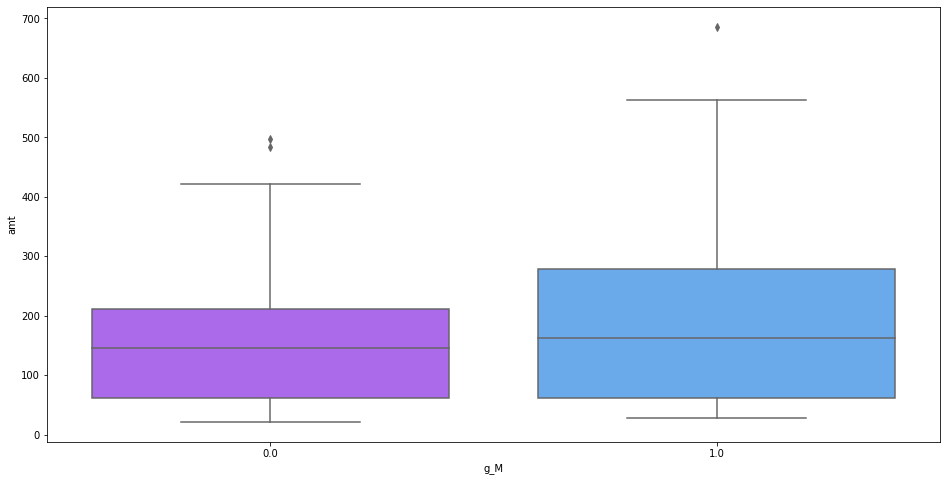

In [135]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='g_M', y='amt', data=df, palette="cool_r")

In [183]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [193]:
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

In [195]:
df_scaled.head()

,age,bal,amt,g_M,t_pay,t_pmt,t_phb,t_pos,t_sales,m_NT,...,b_deg,pca_x,pca_y,_NSW,_QLD,_SA,_TAS,_VIC,_WA,a_sal
0,0.438448,-0.315529,0.200383,-1.128152,-0.826863,0.207533,-0.288791,0.661753,-0.004555,5.872709,...,0.234106,-1.292186,2.407512,-0.524953,-0.379587,-0.327445,-0.133746,-0.748090,-0.399787,1.414508
1,-1.542493,-0.422589,-0.795476,-1.128152,-0.676296,-0.933358,-0.288791,1.433919,1.188161,-0.155969,...,0.009382,0.015840,-0.682744,-0.550113,3.016478,-0.327445,-0.133746,-0.722722,-0.379176,0.010470
2,-0.353928,0.994007,0.576586,0.886405,-0.380482,-1.126118,-0.288791,-0.161261,1.058637,-0.155969,...,-0.936981,0.115012,-0.380429,-0.625031,-0.414090,-0.218750,-0.133746,1.540568,-0.436101,0.826308
3,0.108291,-0.055764,-0.877884,0.886405,-0.645380,0.642786,2.453031,-0.592517,-0.163128,-0.155969,...,-0.083546,-0.598630,-0.218424,-0.350951,-0.249815,-0.304192,-0.133746,-0.778758,0.051159,-0.905442
4,1.032730,0.428751,0.225391,-1.128152,2.343249,-0.960002,-0.288791,-0.905089,-0.766096,-0.155969,...,-0.410918,0.121453,-0.377068,-0.632859,-0.375606,-0.327445,-0.133746,1.178870,-0.436101,-0.309926


In [196]:
df

,age,bal,amt,g_M,t_pay,t_pmt,t_phb,t_pos,t_sales,m_NT,...,b_deg,pca_x,pca_y,_NSW,_QLD,_SA,_TAS,_VIC,_WA,a_sal
acc,,,,,,,,,,,,,,,,,,,,,
958567,34,4736.124598,205.593678,0.0,0.040230,0.281609,0.000000,0.350575,0.293103,0.505747,...,17.327454,-74.407257,92.714269,0.074713,0.017241,0.000000,0.000000,0.028736,0.017241,98493.08
1375564,4,2510.007683,71.145444,0.0,0.050193,0.100386,0.000000,0.428571,0.420849,0.000000,...,3.089790,1.077052,-25.237176,0.061776,1.714286,0.000000,0.000000,0.046332,0.027027,46430.80
1566392,22,31965.638605,256.383837,1.0,0.069767,0.069767,0.000000,0.267442,0.406977,0.000000,...,-56.868299,6.800156,-13.698173,0.023256,0.000000,0.034884,0.000000,1.616279,0.000000,76682.40
2484743,29,10137.490448,60.019776,1.0,0.052239,0.350746,0.097015,0.223881,0.276119,0.000000,...,-2.797769,-34.383113,-7.514613,0.164179,0.082090,0.007463,0.000000,0.007463,0.231343,12468.40
2615387,43,20212.127500,208.970000,0.0,0.250000,0.096154,0.000000,0.192308,0.211538,0.000000,...,-23.538861,7.171829,-13.569880,0.019231,0.019231,0.000000,0.000000,1.365385,0.000000,34550.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827517394,28,28946.555394,65.340485,1.0,0.036364,0.503030,0.000000,0.151515,0.224242,0.000000,...,-20.196708,5.780977,-20.697750,1.327273,0.006061,0.018182,0.000000,0.012121,0.012121,10914.48
3954677887,47,3709.747545,190.124182,0.0,0.118182,0.354545,0.000000,0.236364,0.236364,0.000000,...,64.813547,-11.373774,10.309776,0.100000,0.000000,0.036364,0.000000,0.018182,1.318182,66168.44
4163822186,26,4471.280167,50.813833,0.0,0.200000,0.733333,0.000000,0.016667,0.050000,0.000000,...,-70.033899,5.940977,-18.587489,1.000000,0.016667,0.050000,0.000000,0.000000,0.000000,4450.08


<AxesSubplot:xlabel='g_M', ylabel='amt'>

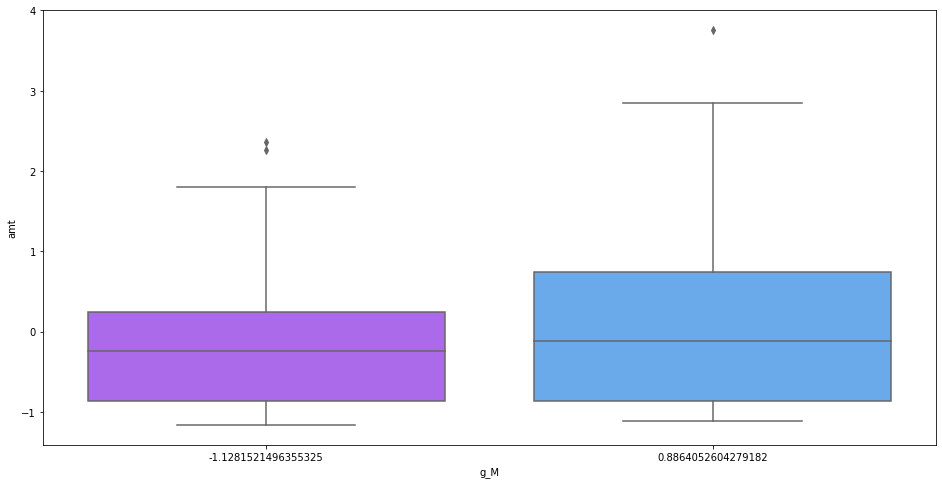

In [194]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='g_M', y='amt', data=df_scaled, palette="cool_r")

In [67]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df_merged)
prof.to_file(output_file='output.html')

## Step 3: Build linear regression model to predict annual salary

### a) Feature selection

In [68]:
features = list(set(df_merged.columns) - set(df_merged[['annualized_sal']]))

In [69]:
X = df_merged[features]
y = df_merged['annualized_sal']
X.head()

,balance,Y,phone_bank,inter_bank,sales_pos,age,pos,payment,gender_M,X
account,,,,,,,,,,
37709441,98107.03,153.41,252.0,1692.0,399.84,18,663.05,2088.0,1,-28.01
38923874,506145.72,151.27,517.5,827.0,734.41,38,1716.74,4671.0,1,-33.90
53508546,54704.11,150.62,517.5,734.5,1204.22,35,350.31,1180.0,0,-33.76
80388494,35050.32,144.97,517.5,270.0,3033.07,28,1356.47,852.0,1,-37.42
90814749,65301.33,151.68,1916.0,902.0,1472.62,35,1845.16,831.0,1,-32.98


In [70]:
# Normalize X using a StandardScalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [71]:
X = pd.DataFrame(X_scaled, columns=X.columns)
X

,balance,Y,phone_bank,inter_bank,sales_pos,age,pos,payment,gender_M,X
0,-0.172917,0.610939,-1.536565,1.338119,-1.026027,-1.198810,-0.668345,0.056973,0.886405,0.196988
1,1.615013,0.478129,-0.129134,-0.084450,-0.736069,0.542381,0.134553,2.459192,0.886405,0.087915
2,-0.363099,0.437789,-0.129134,-0.236574,-0.328904,0.281202,-0.906649,-0.787478,-1.128152,0.090508
3,-0.449217,0.087146,-0.129134,-1.000485,1.256084,-0.328215,-0.139968,-1.092522,0.886405,0.022731
4,-0.316664,0.503574,7.284396,0.038894,-0.096293,0.281202,0.232408,-1.112052,0.886405,0.104952
...,...,...,...,...,...,...,...,...,...,...
95,-0.236044,-1.722547,-0.129134,0.201709,1.547611,-0.937632,-0.711535,1.795164,0.886405,0.126433
96,-0.190322,0.339113,-0.129134,-0.236574,-1.281943,-0.502334,-1.158524,0.386197,-1.128152,0.068101
97,-0.376591,0.116935,-0.129134,-0.342650,0.934684,-0.676453,1.621252,-0.039749,-1.128152,0.016805
98,-0.418764,0.103282,-0.129134,-0.236574,-1.170516,-1.024691,-0.130039,-0.784688,0.886405,0.014583


### b) Linear Regression Model

In [72]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [73]:
# split data again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [74]:
reg = LinearRegression().fit(X_train, y_train)

In [81]:
reg.score(X_train, y_train)

0.4802307603404141

In [82]:
def view_coeff(X, model):
    model_coefs = pd.DataFrame({'variable': X.columns,
                                'coef': model.coef_,
                                'abs_coef': np.abs(model.coef_)})
    model_coefs.sort_values('abs_coef', inplace=True, ascending=False)
    sns.barplot(x="variable", y="coef", data=model_coefs, )

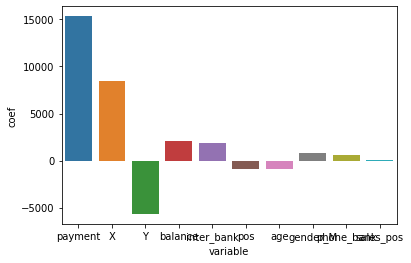

In [83]:
# Plot Coefficients
view_coeff(X, reg)

In [84]:
# Find Optimal Lasso Using LassoCV
optimal_lasso = LassoCV(alphas=lasso_alphas, cv=10)
optimal_lasso.fit(X, y)
print('Alpha:', optimal_lasso.alpha_)
print('Score:', optimal_lasso.score(X, y))

NameError: name 'lasso_alphas' is not defined

In [85]:
# Plot Coefficient
view_coeff(X, optimal_lasso)

NameError: name 'optimal_lasso' is not defined

In [ ]:
X